## Problem Statement and Justification
The stock market often exhibits complex behavior, with different trading days showing distinct volatility, trends, and price movements. Identifying and classifying such patterns without pre-existing labels is a significant challenge. This project addresses the problem by first using K-Means clustering to segment stock market days into behavior-based clusters. These clusters are then used as pseudo-labels in a supervised learning setup. The objective is to train machine learning models that can classify new data into these behavior categories, automating stock market behavior identification.

In [2]:
import pandas as pd 
dataset=pd.read_csv('named_balanced_stock_data.csv')
dataset=dataset.drop(columns='Target',axis=1)
dataset.head()

,Date,Company,Open,High,Low,Close,Volume
0,2020-06-01,Reliance Industries,937.284590,982.885098,910.695548,935.159360,12975
1,2020-06-02,Reliance Industries,927.089366,966.749663,891.112658,901.436536,62400
2,2020-06-03,Reliance Industries,904.524465,937.427179,877.865684,881.473637,67734
3,2020-06-04,Reliance Industries,884.759505,907.770328,851.187678,893.971933,53460
4,2020-06-05,Reliance Industries,879.805997,909.552493,836.758647,848.469025,48336


In [3]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset= dataset.sort_values('Date').reset_index(drop=True)
dataset.head()

,Date,Company,Open,High,Low,Close,Volume
0,2020-06-01,Reliance Industries,937.284590,982.885098,910.695548,935.159360,12975
1,2020-06-01,ICICI Prudential,307.788404,314.013681,296.143040,302.702172,12144
2,2020-06-01,Bajaj Finserv,860.792564,868.111523,841.568429,848.814008,41348
3,2020-06-01,Hero MotoCorp,804.557027,808.207689,801.578816,803.219339,93707
4,2020-06-01,Adani Green,760.047340,772.650037,756.080338,765.571617,78113


In [4]:
dataset.set_index('Date', inplace=True)

In [5]:
dataset.head()

,Company,Open,High,Low,Close,Volume
Date,,,,,,
2020-06-01,Reliance Industries,937.284590,982.885098,910.695548,935.159360,12975
2020-06-01,ICICI Prudential,307.788404,314.013681,296.143040,302.702172,12144
2020-06-01,Bajaj Finserv,860.792564,868.111523,841.568429,848.814008,41348
2020-06-01,Hero MotoCorp,804.557027,808.207689,801.578816,803.219339,93707
2020-06-01,Adani Green,760.047340,772.650037,756.080338,765.571617,78113


## Data Understanding (EDA)
The dataset comprises 77,774 entries from June 2020 to June 2023 for various companies, capturing key stock metrics such as Open, High, Low, Close, and Volume. The closing price trend shows a significant upward trajectory over the three-year period, with notable short-term fluctuations. Moving averages (MA 5 and MA 20) indicate periodic short-term trends and momentum shifts. Daily returns exhibit considerable volatility, with an extreme right-skew in their distribution—suggesting the presence of outliers or sharp gains on rare days. A rolling 5-day standard deviation reveals a steady increase in volatility, especially after mid-2021. Boxplots confirm that price features have a wide range and are influenced by high outliers. Interestingly, the correlation heatmap shows a perfect correlation (≈1.0) among Open, High, Low, and Close prices, which is expected, but almost no correlation between Volume and Daily Return, indicating that trading volume does not directly affect short-term returns. High-volume days (top 5%) are identified for further event-driven analysis. Overall, the stock demonstrates strong upward growth, increasing volatility over time, and strong internal price relationships, making it a candidate for both trend-following and volatility-based strategies

Basic Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 77774 entries, 2020-06-01 to 2023-06-01
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Company  77774 non-null  object 
 1   Open     77774 non-null  float64
 2   High     77774 non-null  float64
 3   Low      77774 non-null  float64
 4   Close    77774 non-null  float64
 5   Volume   77774 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 4.2+ MB
None

Summary Statistics:
               Open          High           Low         Close         Volume
count  77774.000000  77774.000000  77774.000000  77774.000000   77774.000000
mean     622.830492    638.400010    607.237095    622.857449   50365.979093
std      569.928493    584.601494    555.483989    570.312195   28502.333969
min       51.404422     52.624212     49.249348     51.599050    1001.000000
25%      306.971096    314.291493    299.091153    306.762342   25783.250000
50%      

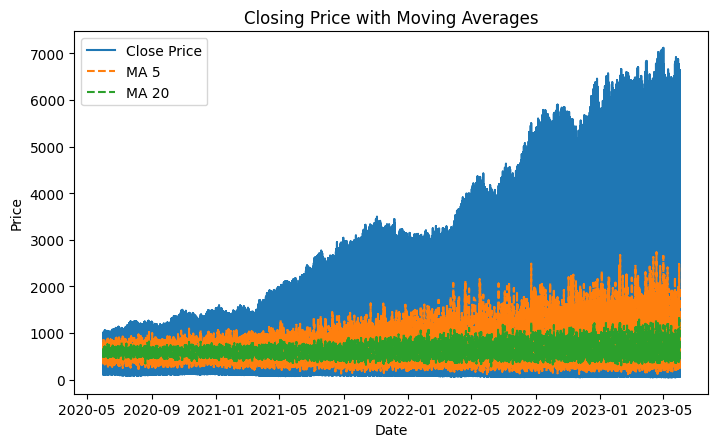

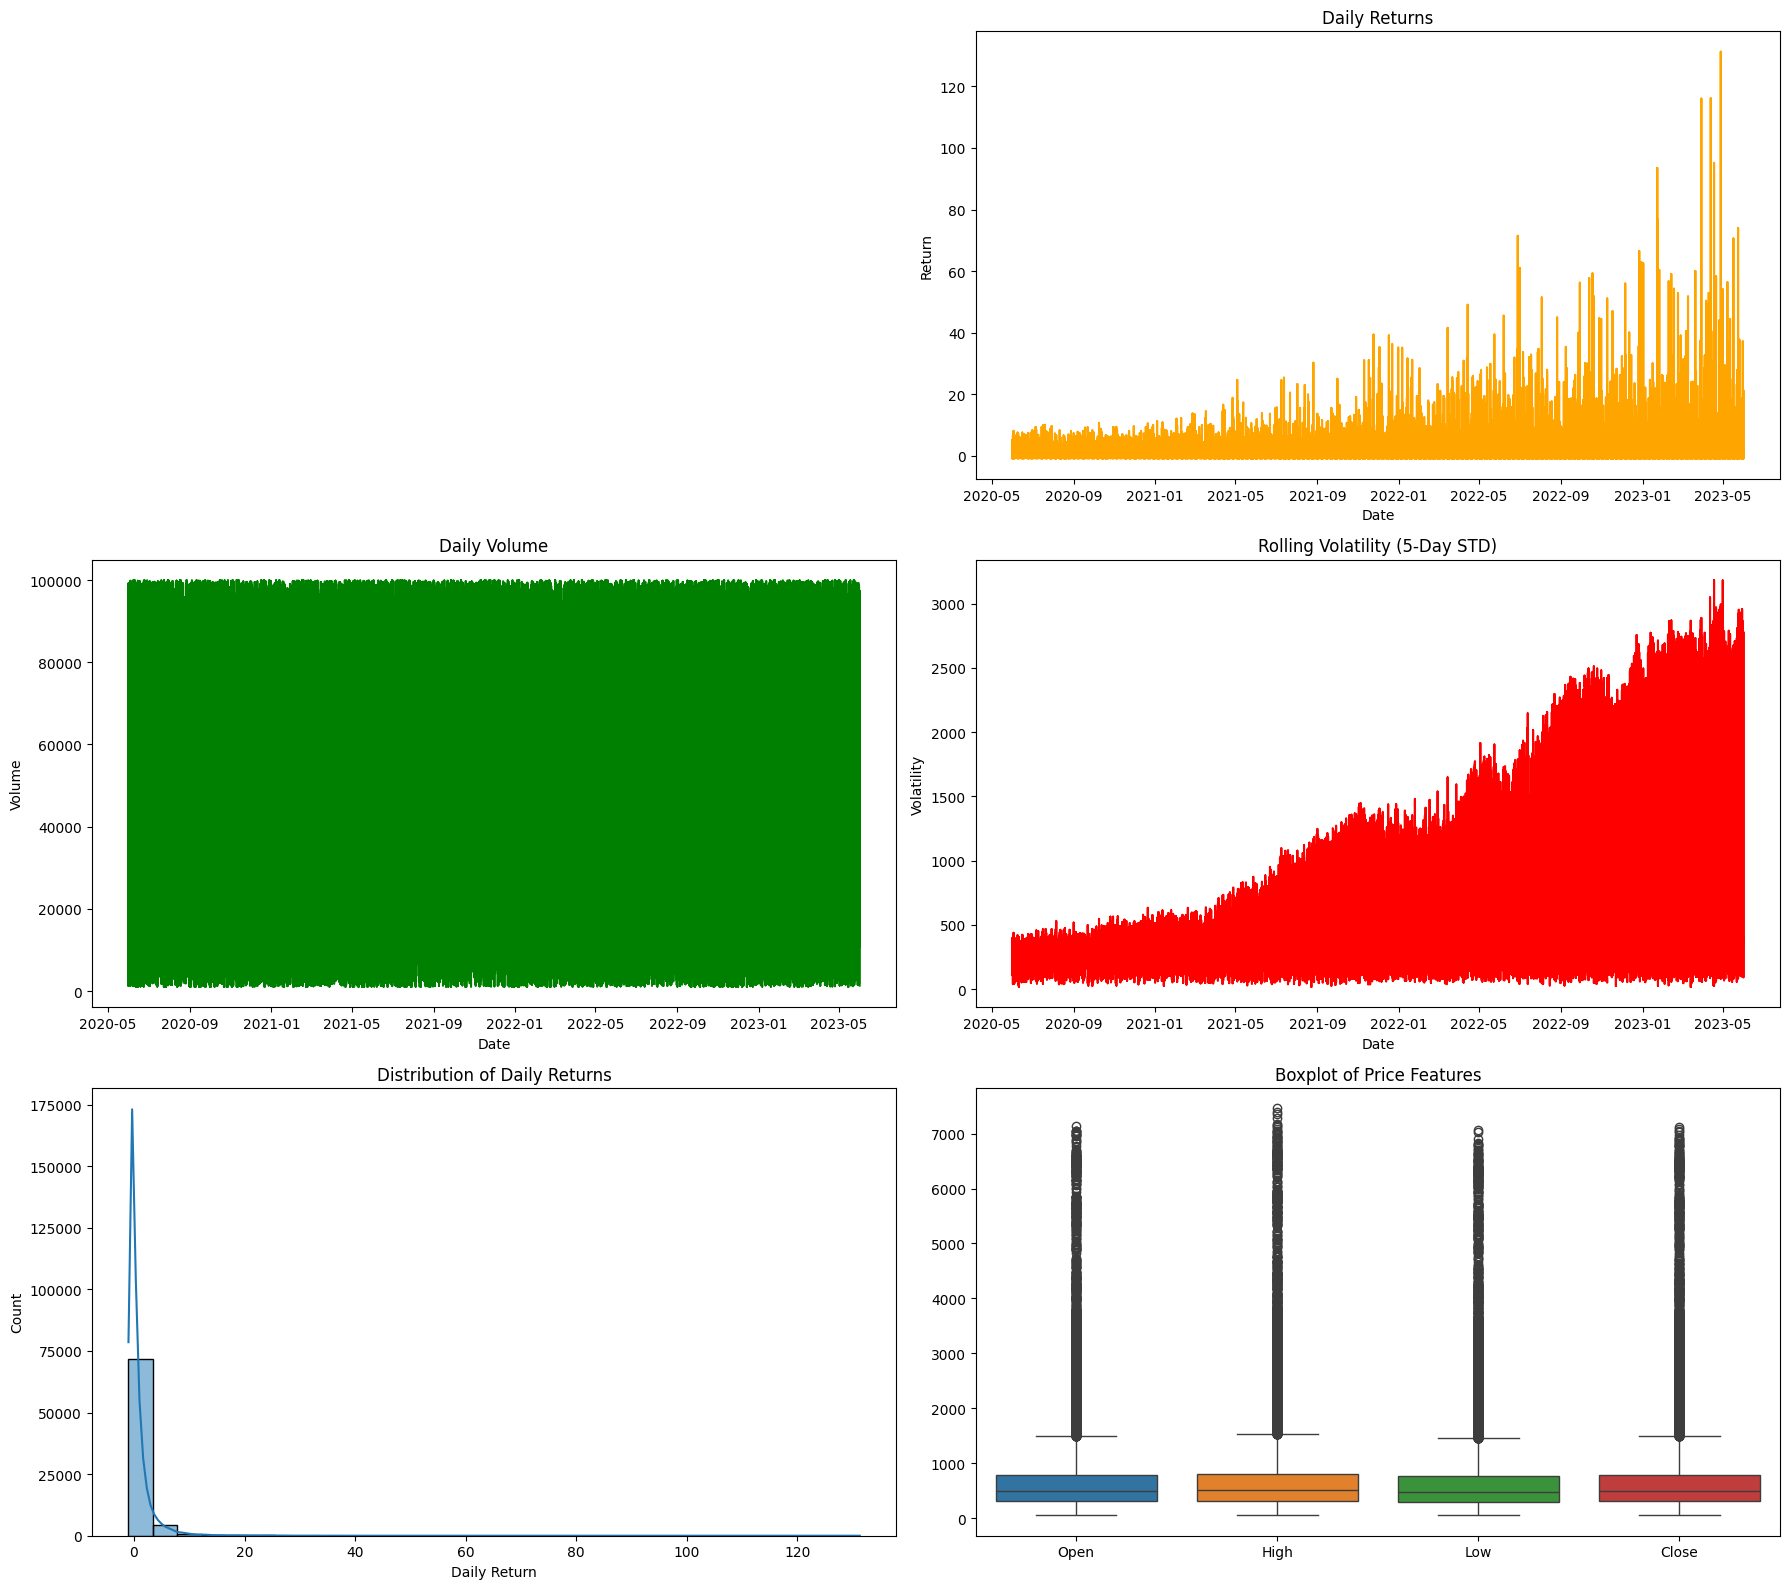

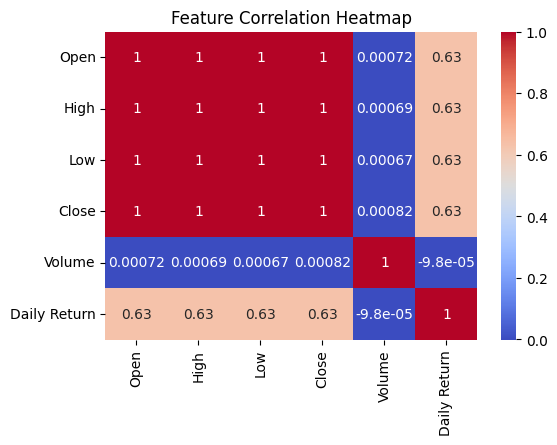


High Volume Days:
            Volume        Close
Date                           
2020-06-01   95168   613.112443
2020-06-01   97177   461.822462
2020-06-01   99178   271.448526
2020-06-01   98902   851.898718
2020-06-02   98953   831.178521
...            ...          ...
2023-05-31   98654   121.437466
2023-05-31   98217   130.169547
2023-06-01   95338   107.695044
2023-06-01   97355  1284.774825
2023-06-01   96689   764.406904

[3889 rows x 2 columns]


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1. Basic info
print("Basic Info:")
print(dataset.info())
print("\nSummary Statistics:")
print(dataset.describe())

# 2. Daily Return
df=dataset
df['Daily Return'] = df['Close'].pct_change()

# 3. Moving Averages
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()

# 4. Rolling Std (Volatility)
df['Rolling_STD_5'] = df['Close'].rolling(window=5).std()

# 5. Visualizations
plt.figure(figsize=(18, 16))

# Closing Price
plt.subplot(3, 2, 1)
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['MA_5'], label='MA 5', linestyle='--')
plt.plot(df.index, df['MA_20'], label='MA 20', linestyle='--')
plt.title('Closing Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()


# Daily Returns
plt.figure(figsize=(18, 16))

plt.subplot(3, 2, 2)
plt.plot(df.index, df['Daily Return'], color='orange')
plt.title('Daily Returns')
plt.xlabel('Date'); plt.ylabel('Return')

# Volume
plt.subplot(3, 2, 3)
plt.plot(df.index, df['Volume'], color='green')
plt.title('Daily Volume')
plt.xlabel('Date'); plt.ylabel('Volume')

# Rolling Std (Volatility)
plt.subplot(3, 2, 4)
plt.plot(df.index, df['Rolling_STD_5'], color='red')
plt.title('Rolling Volatility (5-Day STD)')
plt.xlabel('Date'); plt.ylabel('Volatility')

# Histogram of Returns
plt.subplot(3, 2, 5)
sns.histplot(df['Daily Return'].dropna(), bins=30, kde=True)
plt.title('Distribution of Daily Returns')

# Boxplot of Price Metrics
plt.subplot(3, 2, 6)
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close']])
plt.title('Boxplot of Price Features')

plt.tight_layout()
plt.show()

# 6. Correlation Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume', 'Daily Return']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# 7. High Volume Days
high_volume_days = df[df['Volume'] > df['Volume'].quantile(0.95)]
print("\nHigh Volume Days:")
print(high_volume_days[['Volume', 'Close']])

In [7]:
dataset=dataset.drop(columns=['MA_5','MA_20','Rolling_STD_5'])
dataset.dropna()


,Company,Open,High,Low,Close,Volume,Daily Return
Date,,,,,,,
2020-06-01,ICICI Prudential,307.788404,314.013681,296.143040,302.702172,12144,-0.676310
2020-06-01,Bajaj Finserv,860.792564,868.111523,841.568429,848.814008,41348,1.804123
2020-06-01,Hero MotoCorp,804.557027,808.207689,801.578816,803.219339,93707,-0.053716
2020-06-01,Adani Green,760.047340,772.650037,756.080338,765.571617,78113,-0.046871
2020-06-01,GAIL,420.028536,430.440551,417.405237,419.927069,13614,-0.451486
...,...,...,...,...,...,...,...
2023-06-01,Pidilite,107.192808,108.675192,103.108580,106.396803,9801,-0.483369
2023-06-01,Dabur,1074.617529,1090.551642,1059.254433,1073.410986,2427,9.088752
2023-06-01,Zomato,323.647018,329.716560,312.735745,320.526348,51759,-0.701395


## Data preparation & Feature engineering 


To enhance the dataset's predictive power, several meaningful features were engineered from the existing stock data. First, temporal decomposition was performed by extracting the **day, month, year, and day of the week** from the `Date` index. This allows models to capture potential **seasonal or weekday-based trends** in stock behavior. Next, several price-based indicators were created to summarize intraday dynamics: `Price_Range` captures the spread between high and low prices, `Open_Close_Change` measures the net price movement during the day, and `High_Close_Diff` and `Low_Close_Diff` help quantify end-of-day deviations from intraday extremes. We also calculated `Daily_Volatility_Pct` as a normalized volatility measure and `Return_Pct` to represent percentage gains or losses throughout the day — both of which are important for modeling risk and return. In addition, we identified and displayed the top 10 companies with the highest average closing prices to analyze dominant trends. Finally, **one-hot encoding** was applied to categorical features like company names to prepare the data for machine learning models, and **standard scaling** was performed to normalize feature ranges and ensure consistent model performance across all features.

In [8]:
dataset['Price_Range'] = dataset['High'] - dataset['Low']
dataset['Open_Close_Change'] = dataset['Close'] - dataset['Open']
dataset['High_Close_Diff'] = dataset['High'] - dataset['Close']
dataset['Low_Close_Diff'] = dataset['Close'] - dataset['Low']
dataset['Daily_Volatility_Pct'] = (dataset['High'] - dataset['Low']) / dataset['Open']
dataset['Return_Pct'] = (dataset['Close'] - dataset['Open']) / dataset['Open'] * 100
dataset.head()


,Company,Open,High,Low,Close,Volume,Daily Return,Price_Range,Open_Close_Change,High_Close_Diff,Low_Close_Diff,Daily_Volatility_Pct,Return_Pct
Date,,,,,,,,,,,,,
2020-06-01,Reliance Industries,937.284590,982.885098,910.695548,935.159360,12975,NaN,72.189551,-2.125230,47.725738,24.463812,0.077020,-0.226743
2020-06-01,ICICI Prudential,307.788404,314.013681,296.143040,302.702172,12144,-0.676310,17.870641,-5.086232,11.311510,6.559131,0.058061,-1.652509
2020-06-01,Bajaj Finserv,860.792564,868.111523,841.568429,848.814008,41348,1.804123,26.543094,-11.978556,19.297515,7.245579,0.030836,-1.391573
2020-06-01,Hero MotoCorp,804.557027,808.207689,801.578816,803.219339,93707,-0.053716,6.628873,-1.337689,4.988350,1.640523,0.008239,-0.166264
2020-06-01,Adani Green,760.047340,772.650037,756.080338,765.571617,78113,-0.046871,16.569699,5.524277,7.078420,9.491279,0.021801,0.726833


In [9]:
# Assuming dataset already has Date as the index
dataset['Day'] = dataset.index.day
dataset['Month'] = dataset.index.month
dataset['Year'] = dataset.index.year
dataset['DayOfWeek'] = dataset.index.dayofweek  # 0 = Monday, 6 = Sunday


In [10]:
dataset.head()

,Company,Open,High,Low,Close,Volume,Daily Return,Price_Range,Open_Close_Change,High_Close_Diff,Low_Close_Diff,Daily_Volatility_Pct,Return_Pct,Day,Month,Year,DayOfWeek
Date,,,,,,,,,,,,,,,,,
2020-06-01,Reliance Industries,937.284590,982.885098,910.695548,935.159360,12975,NaN,72.189551,-2.125230,47.725738,24.463812,0.077020,-0.226743,1,6,2020,0
2020-06-01,ICICI Prudential,307.788404,314.013681,296.143040,302.702172,12144,-0.676310,17.870641,-5.086232,11.311510,6.559131,0.058061,-1.652509,1,6,2020,0
2020-06-01,Bajaj Finserv,860.792564,868.111523,841.568429,848.814008,41348,1.804123,26.543094,-11.978556,19.297515,7.245579,0.030836,-1.391573,1,6,2020,0
2020-06-01,Hero MotoCorp,804.557027,808.207689,801.578816,803.219339,93707,-0.053716,6.628873,-1.337689,4.988350,1.640523,0.008239,-0.166264,1,6,2020,0
2020-06-01,Adani Green,760.047340,772.650037,756.080338,765.571617,78113,-0.046871,16.569699,5.524277,7.078420,9.491279,0.021801,0.726833,1,6,2020,0


In [11]:
# dataset.reset_index(drop=True, inplace=True)


In [12]:
dataset.head()

,Company,Open,High,Low,Close,Volume,Daily Return,Price_Range,Open_Close_Change,High_Close_Diff,Low_Close_Diff,Daily_Volatility_Pct,Return_Pct,Day,Month,Year,DayOfWeek
Date,,,,,,,,,,,,,,,,,
2020-06-01,Reliance Industries,937.284590,982.885098,910.695548,935.159360,12975,NaN,72.189551,-2.125230,47.725738,24.463812,0.077020,-0.226743,1,6,2020,0
2020-06-01,ICICI Prudential,307.788404,314.013681,296.143040,302.702172,12144,-0.676310,17.870641,-5.086232,11.311510,6.559131,0.058061,-1.652509,1,6,2020,0
2020-06-01,Bajaj Finserv,860.792564,868.111523,841.568429,848.814008,41348,1.804123,26.543094,-11.978556,19.297515,7.245579,0.030836,-1.391573,1,6,2020,0
2020-06-01,Hero MotoCorp,804.557027,808.207689,801.578816,803.219339,93707,-0.053716,6.628873,-1.337689,4.988350,1.640523,0.008239,-0.166264,1,6,2020,0
2020-06-01,Adani Green,760.047340,772.650037,756.080338,765.571617,78113,-0.046871,16.569699,5.524277,7.078420,9.491279,0.021801,0.726833,1,6,2020,0


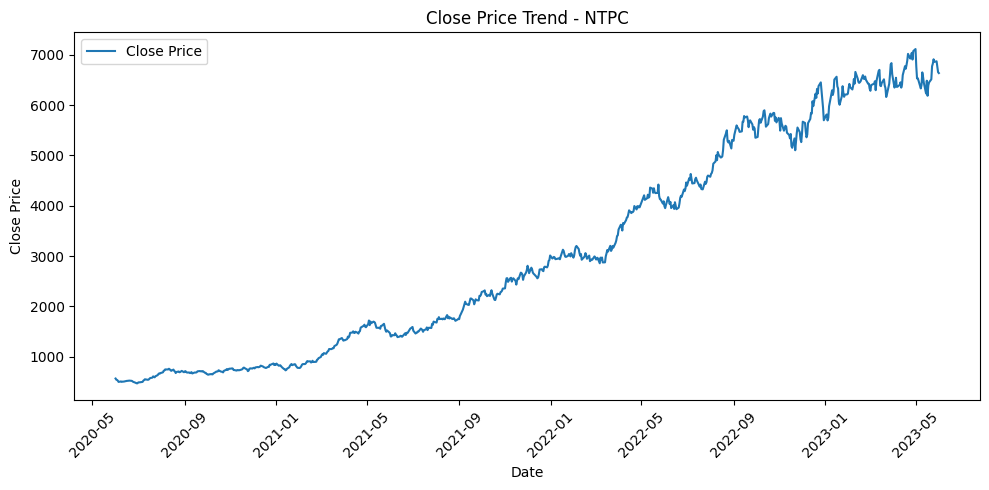

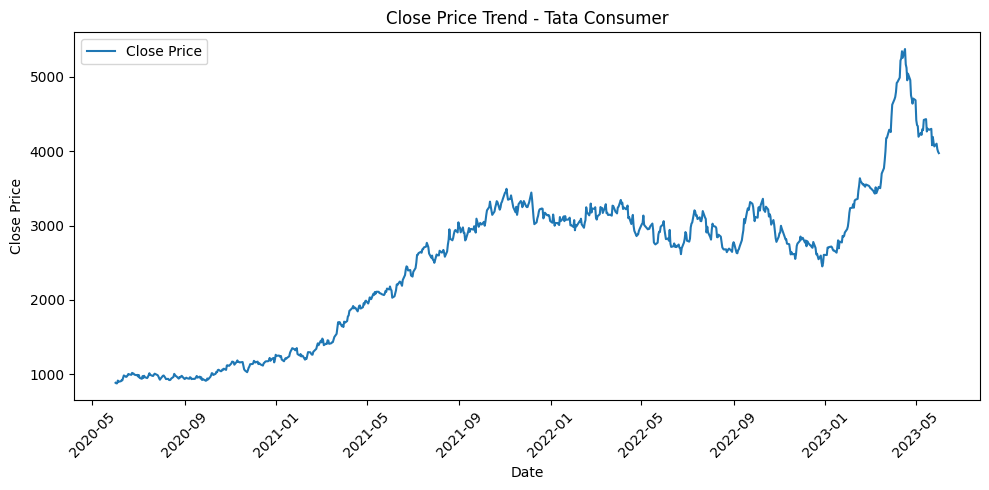

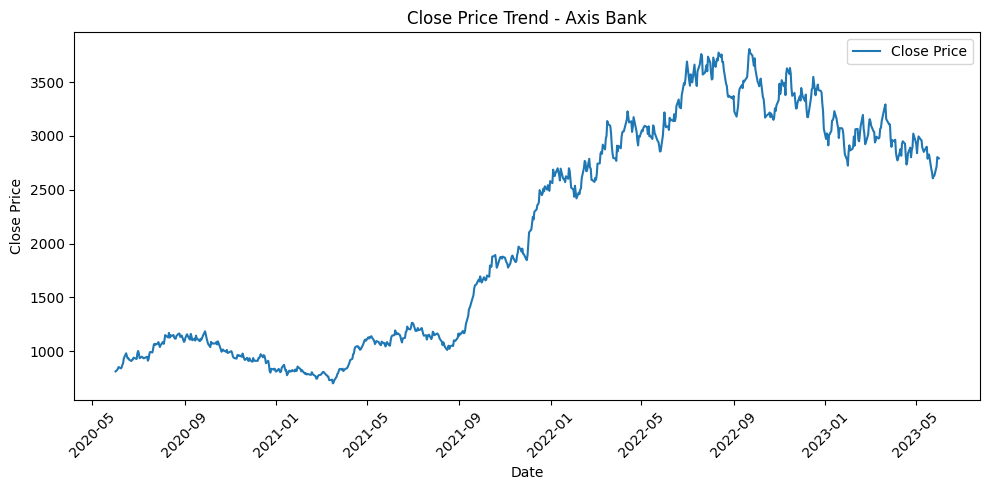

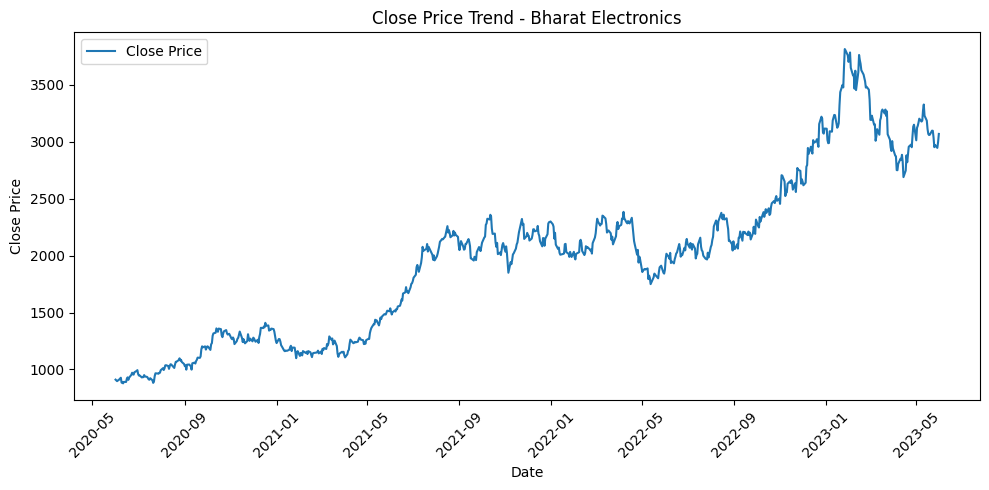

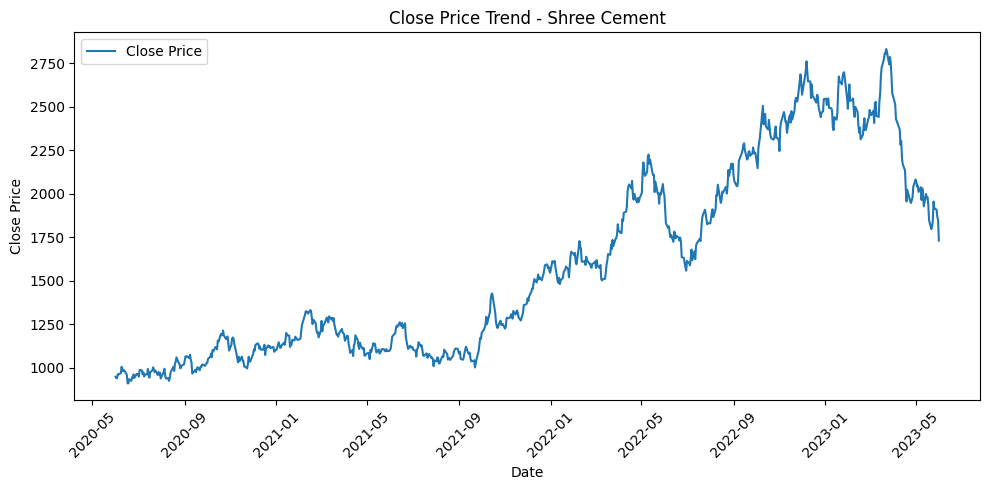

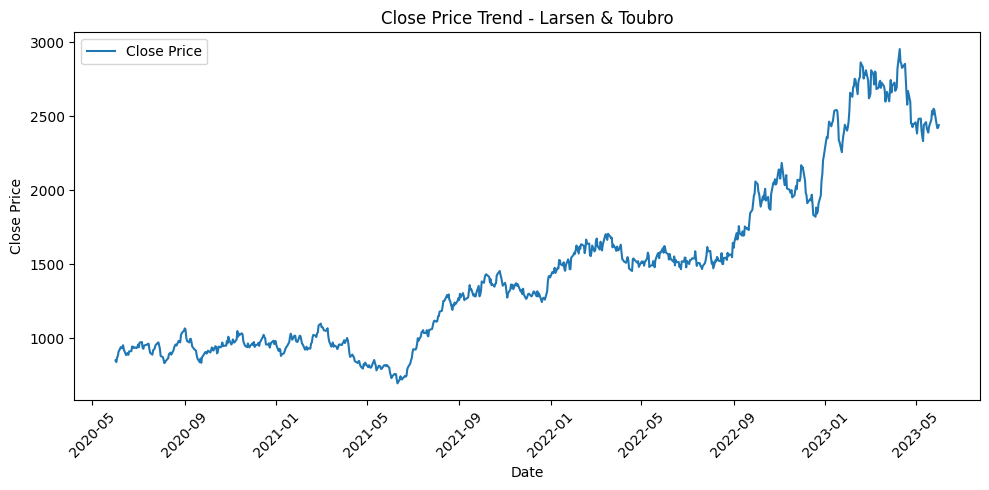

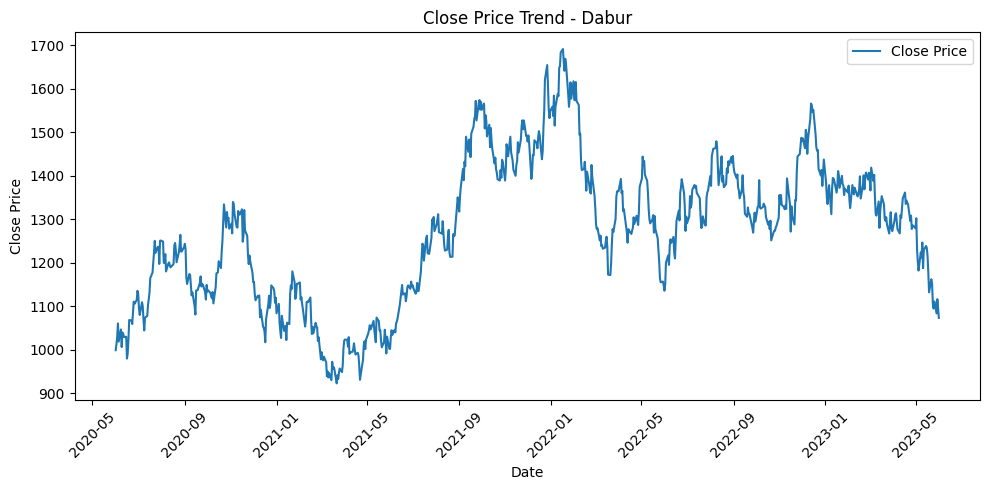

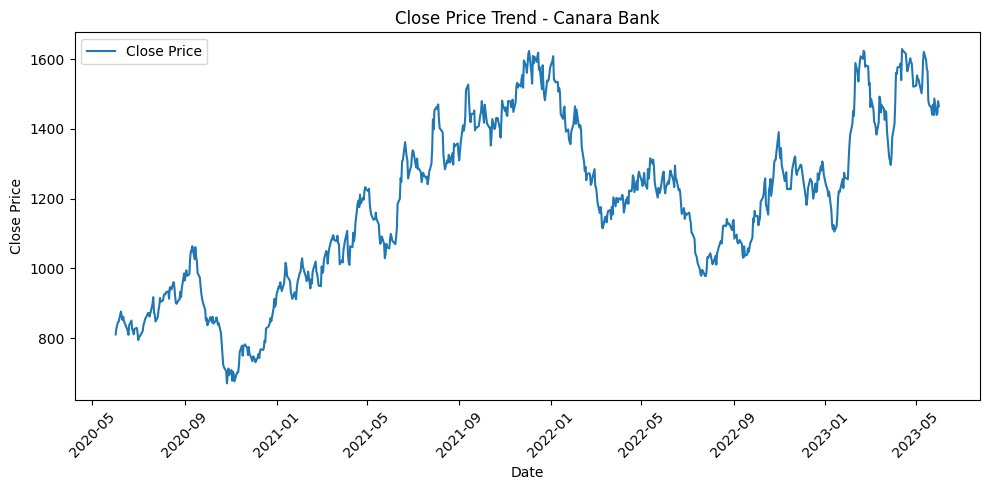

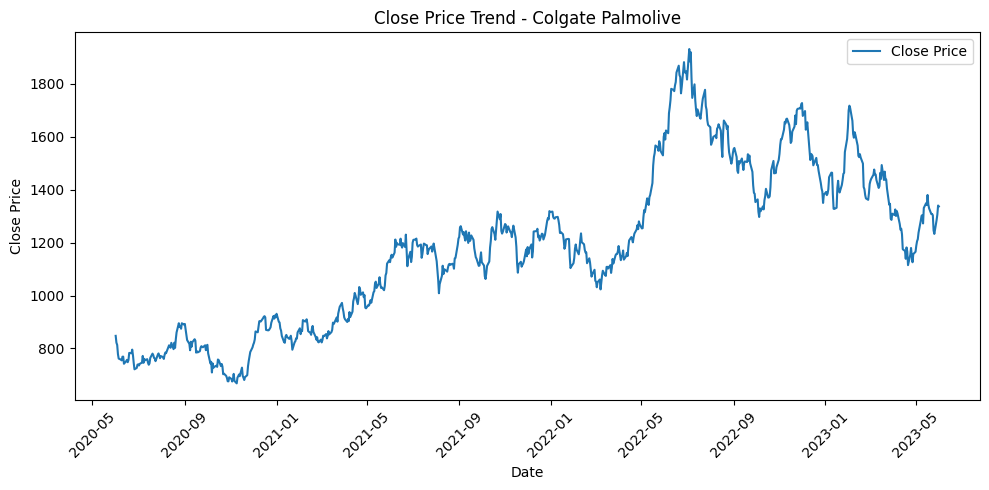

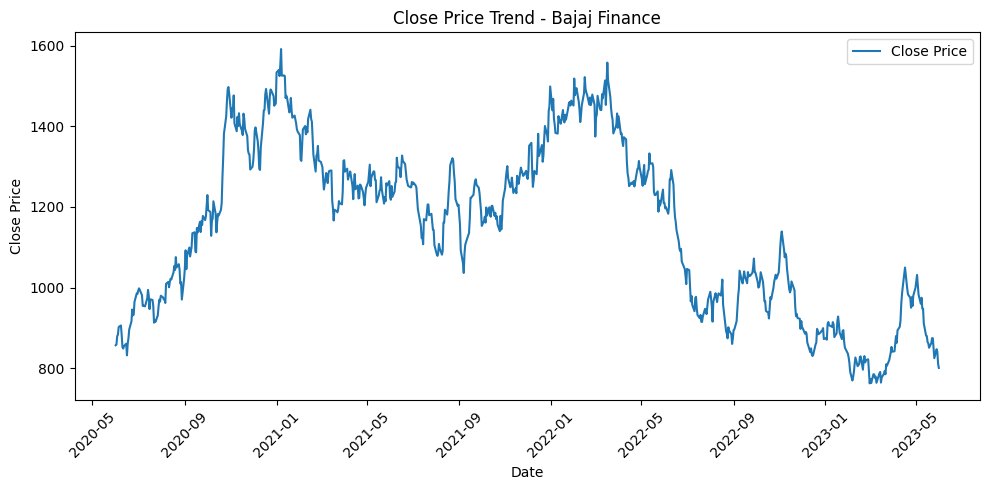

In [13]:
import matplotlib.pyplot as plt

# Step 1: Calculate average Close price per company
avg_close = dataset.groupby('Company')['Close'].mean()

# Step 2: Get top 10 companies by average Close price
top_10_companies = avg_close.sort_values(ascending=False).head(10).index

# Step 3: Plot separate graphs for these top 10 companies
for company in top_10_companies:
    company_data = dataset[dataset['Company'] == company]
    
    plt.figure(figsize=(10, 5))
    plt.plot(company_data.index, company_data['Close'], label='Close Price')
    
    plt.title(f'Close Price Trend - {company}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()



In [14]:
# Drop index if date is index
dataset = dataset.reset_index(drop=True)


# One-hot encode company column
dataset = pd.get_dummies(dataset, columns=['Company'], drop_first=False)
dataset.head()

,Open,High,Low,Close,Volume,Daily Return,Price_Range,Open_Close_Change,High_Close_Diff,Low_Close_Diff,...,Company_Titan Company,Company_Torrent Pharma,Company_Trent,Company_UltraTech Cement,Company_United Spirits,Company_Varun Beverages,Company_Vedanta,Company_Wipro,Company_Yes Bank,Company_Zomato
0,937.284590,982.885098,910.695548,935.159360,12975,NaN,72.189551,-2.125230,47.725738,24.463812,...,False,False,False,False,False,False,False,False,False,False
1,307.788404,314.013681,296.143040,302.702172,12144,-0.676310,17.870641,-5.086232,11.311510,6.559131,...,False,False,False,False,False,False,False,False,False,False
2,860.792564,868.111523,841.568429,848.814008,41348,1.804123,26.543094,-11.978556,19.297515,7.245579,...,False,False,False,False,False,False,False,False,False,False
3,804.557027,808.207689,801.578816,803.219339,93707,-0.053716,6.628873,-1.337689,4.988350,1.640523,...,False,False,False,False,False,False,False,False,False,False
4,760.047340,772.650037,756.080338,765.571617,78113,-0.046871,16.569699,5.524277,7.078420,9.491279,...,False,False,False,False,False,False,False,False,False,False


In [15]:
import numpy as np
dataset = dataset.replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
dataset = dataset.dropna()

# Step 2: (Optional) Round numeric values before converting to integers
dataset = dataset.astype(int)

# Step 3: Display the cleaned dataset
dataset.head() 

,Open,High,Low,Close,Volume,Daily Return,Price_Range,Open_Close_Change,High_Close_Diff,Low_Close_Diff,...,Company_Titan Company,Company_Torrent Pharma,Company_Trent,Company_UltraTech Cement,Company_United Spirits,Company_Varun Beverages,Company_Vedanta,Company_Wipro,Company_Yes Bank,Company_Zomato
1,307,314,296,302,12144,0,17,-5,11,6,...,0,0,0,0,0,0,0,0,0,0
2,860,868,841,848,41348,1,26,-11,19,7,...,0,0,0,0,0,0,0,0,0,0
3,804,808,801,803,93707,0,6,-1,4,1,...,0,0,0,0,0,0,0,0,0,0
4,760,772,756,765,78113,0,16,5,7,9,...,0,0,0,0,0,0,0,0,0,0
5,420,430,417,419,13614,0,13,0,10,2,...,0,0,0,0,0,0,0,0,0,0


In [16]:
from sklearn.preprocessing import StandardScaler
X = dataset


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)




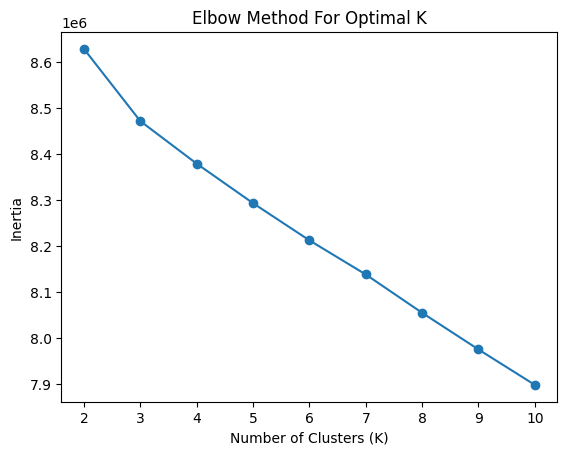

In [17]:
# 3. Find best K
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# 4. Plot elbow curve
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()



### Feature Selection :

In this analysis, all engineered and original features were retained for modeling to fully leverage the available information. Temporal features such as `Day`, `Month`, `Year`, and `DayOfWeek` were included to capture potential seasonal trends and day-specific patterns in stock behavior. Engineered features like `Price_Range`, `Open_Close_Change`, `High_Close_Diff`, `Low_Close_Diff`, `Daily_Volatility_Pct`, and `Return_Pct` were incorporated to reflect daily price dynamics and volatility, which are critical for financial forecasting. Additionally, categorical variables like `Company` were transformed using one-hot encoding to ensure compatibility with machine learning algorithms. All numerical features were standardized using **StandardScaler** to ensure that features with larger scales did not dominate the model training process. By including all features, we aimed to preserve the full spectrum of potentially valuable signals in the dataset for model learning.


###  Modeling :

To classify stock behavior based on the engineered features, K-Means clustering was first applied to uncover natural groupings within the data, with the optimal number of clusters determined as **K = 4**. These clusters—ranging from premium high-volatility stocks to low-price stable stocks—were then used as **class labels**, enabling a transition from unsupervised to supervised learning. The labeled dataset was split into training and testing sets using `train_test_split`, and three classification models were trained: a **Random Forest Classifier** for its ensemble robustness, **Histogram-Based Gradient Boosting (HGB)** for its efficiency on tabular numerical data, and a **Support Vector Machine (SVM)** to maximize class separation in the feature space. Each model was evaluated based on its ability to accurately predict the assigned cluster label, thereby learning to identify stock behavior patterns from the engineered features.


In [18]:
best_k = 4  # or try 5 and compare
kmeans = KMeans(n_clusters=best_k, random_state=42)
dataset['cluster_label'] = kmeans.fit_predict(X_scaled)


In [19]:
dataset.head()

,Open,High,Low,Close,Volume,Daily Return,Price_Range,Open_Close_Change,High_Close_Diff,Low_Close_Diff,...,Company_Torrent Pharma,Company_Trent,Company_UltraTech Cement,Company_United Spirits,Company_Varun Beverages,Company_Vedanta,Company_Wipro,Company_Yes Bank,Company_Zomato,cluster_label
1,307,314,296,302,12144,0,17,-5,11,6,...,0,0,0,0,0,0,0,0,0,0
2,860,868,841,848,41348,1,26,-11,19,7,...,0,0,0,0,0,0,0,0,0,2
3,804,808,801,803,93707,0,6,-1,4,1,...,0,0,0,0,0,0,0,0,0,1
4,760,772,756,765,78113,0,16,5,7,9,...,0,0,0,0,0,0,0,0,0,2
5,420,430,417,419,13614,0,13,0,10,2,...,0,0,0,0,0,0,0,0,0,0


In [20]:

dataset.head()

,Open,High,Low,Close,Volume,Daily Return,Price_Range,Open_Close_Change,High_Close_Diff,Low_Close_Diff,...,Company_Torrent Pharma,Company_Trent,Company_UltraTech Cement,Company_United Spirits,Company_Varun Beverages,Company_Vedanta,Company_Wipro,Company_Yes Bank,Company_Zomato,cluster_label
1,307,314,296,302,12144,0,17,-5,11,6,...,0,0,0,0,0,0,0,0,0,0
2,860,868,841,848,41348,1,26,-11,19,7,...,0,0,0,0,0,0,0,0,0,2
3,804,808,801,803,93707,0,6,-1,4,1,...,0,0,0,0,0,0,0,0,0,1
4,760,772,756,765,78113,0,16,5,7,9,...,0,0,0,0,0,0,0,0,0,2
5,420,430,417,419,13614,0,13,0,10,2,...,0,0,0,0,0,0,0,0,0,0


In [21]:


# 1️⃣ Identify columns to exclude
company_columns = [col for col in dataset.columns if col.startswith('company_')]

# 2️⃣ Identify columns to include in mean calculation
feature_columns = [col for col in dataset.columns if col not in company_columns + ['cluster_label']]

# 3️⃣ Group by cluster_label and compute mean of desired columns
cluster_means = dataset.groupby('cluster_label')[feature_columns].mean()

# 4️⃣ Display result



In [22]:
cluster_means.head()

,Open,High,Low,Close,Volume,Daily Return,Price_Range,Open_Close_Change,High_Close_Diff,Low_Close_Diff,...,Company_Titan Company,Company_Torrent Pharma,Company_Trent,Company_UltraTech Cement,Company_United Spirits,Company_Varun Beverages,Company_Vedanta,Company_Wipro,Company_Yes Bank,Company_Zomato
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,276.155075,283.002705,269.193586,276.011463,50469.036611,0.097694,13.306157,-0.143805,6.502061,6.331015,...,0.000000,0.025019,0.024923,0.000000,0.000000,0.023216,0.000000,0.024923,0.00000,0.000000
1,582.056854,596.476851,567.494496,581.893229,50243.768323,0.519756,28.480094,-0.159818,14.086111,13.904351,...,0.029407,0.000000,0.000000,0.029445,0.000000,0.000000,0.000000,0.000000,0.02937,0.029294
2,981.579488,1005.954460,957.487414,981.895010,50347.930559,1.386233,47.967763,0.303323,23.566957,23.912508,...,0.000000,0.000000,0.000000,0.000000,0.043001,0.003202,0.043001,0.000000,0.00000,0.000000
3,3179.186808,3262.998074,3095.423688,3181.679827,50561.127106,8.848339,167.062590,2.440058,80.811266,85.747232,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000


In [23]:
# Define mapping
cluster_name_mapping = {
    0: "Mid-price, moderately volatile, diversified",
    1: "Premium high-volatility stocks",
    2: "High-mid price sector-specific stocks",
    3: "Low-price, stable stocks"
}

# Create a new column with cluster name
dataset['cluster_category'] = dataset['cluster_label'].map(cluster_name_mapping)

# Check
dataset[['cluster_label', 'cluster_category']].head()



,cluster_label,cluster_category
1,0,"Mid-price, moderately volatile, diversified"
2,2,High-mid price sector-specific stocks
3,1,Premium high-volatility stocks
4,2,High-mid price sector-specific stocks
5,0,"Mid-price, moderately volatile, diversified"


In [24]:
dataset.head()

,Open,High,Low,Close,Volume,Daily Return,Price_Range,Open_Close_Change,High_Close_Diff,Low_Close_Diff,...,Company_Trent,Company_UltraTech Cement,Company_United Spirits,Company_Varun Beverages,Company_Vedanta,Company_Wipro,Company_Yes Bank,Company_Zomato,cluster_label,cluster_category
1,307,314,296,302,12144,0,17,-5,11,6,...,0,0,0,0,0,0,0,0,0,"Mid-price, moderately volatile, diversified"
2,860,868,841,848,41348,1,26,-11,19,7,...,0,0,0,0,0,0,0,0,2,High-mid price sector-specific stocks
3,804,808,801,803,93707,0,6,-1,4,1,...,0,0,0,0,0,0,0,0,1,Premium high-volatility stocks
4,760,772,756,765,78113,0,16,5,7,9,...,0,0,0,0,0,0,0,0,2,High-mid price sector-specific stocks
5,420,430,417,419,13614,0,13,0,10,2,...,0,0,0,0,0,0,0,0,0,"Mid-price, moderately volatile, diversified"


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Example: load your data (replace with your real dataframe)
# dataset = pd.read_csv('your_stock_data_with_clusters.csv')

# Features and target
X = dataset.drop(columns=['cluster_label','cluster_category'])  # all columns except target
y = dataset['cluster_label']  # cluster labels as target

# Split into train/test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test data
y_pred = clf.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.996142719382835

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6211
           1       1.00      1.00      1.00      5305
           2       0.99      0.99      0.99      3623
           3       0.97      0.96      0.96       416

    accuracy                           1.00     15555
   macro avg       0.99      0.99      0.99     15555
weighted avg       1.00      1.00      1.00     15555


Confusion Matrix:
 [[6205    4    2    0]
 [   1 5301    3    0]
 [   2   18 3591   12]
 [   0    0   18  398]]


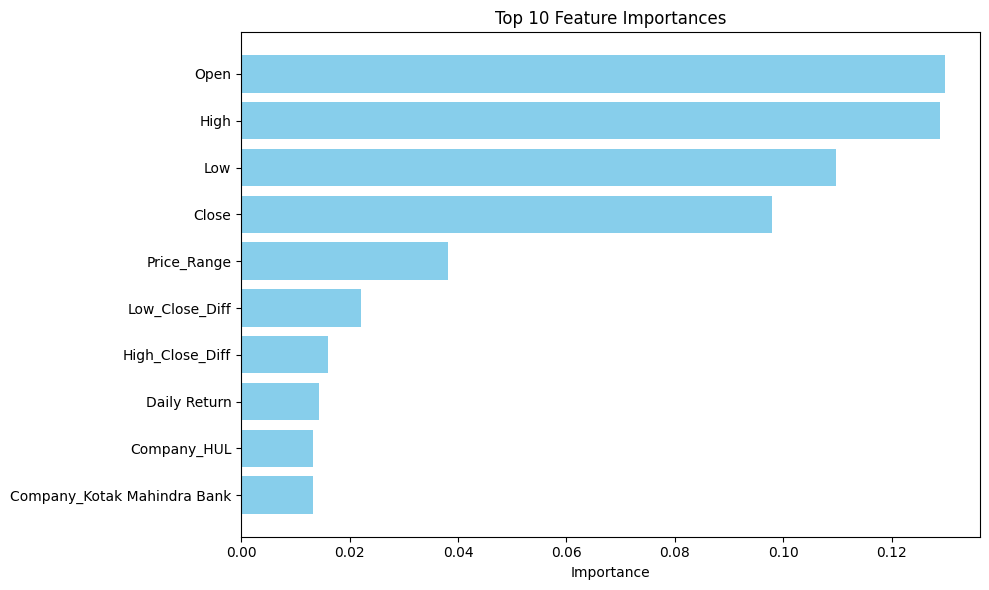

In [26]:


importances = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier handling
import pandas as pd

feature_dataset = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top10_features = feature_dataset.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top10_features['Feature'], top10_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [27]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize Gradient Boosting classifier
gb_clf = HistGradientBoostingClassifier(random_state=42)

# Train the model
gb_clf.fit(X_train, y_train)

# Predict on test data
y_pred_gb = gb_clf.predict(X_test)

# Evaluate
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nGradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))
print("\nGradient Boosting Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))


Gradient Boosting Accuracy: 0.9982642237222757

Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6211
           1       1.00      1.00      1.00      5305
           2       1.00      1.00      1.00      3623
           3       0.98      0.98      0.98       416

    accuracy                           1.00     15555
   macro avg       0.99      0.99      0.99     15555
weighted avg       1.00      1.00      1.00     15555


Gradient Boosting Confusion Matrix:
 [[6210    0    1    0]
 [   0 5302    3    0]
 [   2    5 3608    8]
 [   0    0    8  408]]


In [28]:


from sklearn.svm import SVC

# Train SVM
X_Scaled_Train = scaler.fit_transform(X_train)
X_Scaled_Test = scaler.transform(X_test)  # only transform here!

svm_clf = SVC()
svm_clf.fit(X_Scaled_Train, y_train)

# Predict
y_pred_svm = svm_clf.predict(X_Scaled_Test)

# Evaluate
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nSVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("\nSVM Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))


SVM Accuracy: 0.997621343619415

SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6211
           1       1.00      1.00      1.00      5305
           2       1.00      0.99      0.99      3623
           3       0.99      0.99      0.99       416

    accuracy                           1.00     15555
   macro avg       1.00      1.00      1.00     15555
weighted avg       1.00      1.00      1.00     15555


SVM Confusion Matrix:
 [[6203    0    8    0]
 [   0 5302    3    0]
 [   7   10 3602    4]
 [   0    0    5  411]]


###  Evaluation:

All three supervised models demonstrated exceptional performance in classifying the stock behavior clusters, with **accuracy scores exceeding 99.7%**. The **Random Forest Classifier** achieved an accuracy of **99.61%**, showing strong performance across all clusters with minimal misclassifications—primarily between clusters 0 and 2. The **Histogram-Based Gradient Boosting (HGB)** model outperformed the others slightly, reaching an accuracy of **99.83%**, and displayed the best overall precision, recall, and f1-scores, especially for the smaller class (Cluster 3). The **Support Vector Machine (SVM)** model also performed excellently, with a **99.76%** accuracy and high consistency across all metrics. Confusion matrix analysis confirmed the low rate of misclassification across all models, highlighting their effectiveness in distinguishing nuanced market behavior patterns derived from the K-Means-generated labels.


In [29]:
import joblib
# Save model to file
joblib.dump(gb_clf, 'gb_clf_model.pkl')


['gb_clf_model.pkl']

### Deployment Summary:

To deploy the stock behavior classification app, **Streamlit Community Cloud** is recommended for its simplicity and free access for public projects. The deployment process involves pushing all necessary files—such as `app.py`, the trained model, and `requirements.txt`—to a GitHub repository. Once the repository is connected to a **Streamlit Cloud** account, the app can be launched by selecting the appropriate branch and entry-point script (`app.py`). Streamlit automatically installs dependencies from the `requirements.txt` file and hosts the app online, enabling real-time interaction with your model through a user-friendly web interface without the need for complex infrastructure.


In [30]:
dataset.to_csv('dataset_one_hot_encoded.csv')